In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from IPython.display import clear_output

In [2]:
def read_kImage(path):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(path)
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    return ct_scan

In [3]:
def extract_voxel_data(series_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( series_path )
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image_3d = sitk.GetArrayFromImage(image)
    return image_3d

In [4]:
def normalize_image(image_3D):
    z,y,x = image_3D.shape
    new_image_3D = np.empty(shape = (z,y,x) )
    target_min = -1
    target_max = 1
    for i in range (z):
        max_value = np.max (image_3D[i])
        min_value = np.min (image_3D[i])
        new_image_3D[i] = (image_3D[i] - min_value)*(float(target_max - target_min)/(max_value - min_value)) + target_min
    return new_image_3D

In [5]:
def subvoxel (img_3d,ijk, window):
    ijk = ijk.split()
    x = int(ijk[0])
    y = int(ijk[1])
    z = int(ijk[2])
    if (z < 0):
        z = z*(-1)
    new_img3d = np.empty(shape = (3,img_3d.shape[1], img_3d.shape[2]))
    max_bandwith = img_3d.shape[0] - 1
    if ( z == max_bandwith ):
        new_img3d[0,:,:] = img_3d[z-1,:,:] #n-1
        new_img3d[1,:,:] = img_3d[z,:,:] #n
        new_img3d[2,:,:] = img_3d[z,:,:] #n
    else:
        if (z == 0):
            new_img3d[0,:,:] = img_3d[z,:,:] #0
            new_img3d[1,:,:] = img_3d[z,:,:] #0
            new_img3d[2,:,:] = img_3d[z+1,:,:] #1
        else:
            new_img3d[0,:,:] = img_3d[z-1,:,:] #n-1
            new_img3d[1,:,:] = img_3d[z,:,:] #n
            new_img3d[2,:,:] = img_3d[z+1,:,:] #n+1
    window = window//2
    new_img3d = new_img3d[:, y-window : y+window, x-window : x+window]
    return new_img3d

In [6]:
def generate_training_dataframes():
    basedir = "../1/train/ProstateX-TrainingLesionInformationv2/ProstateX-TrainingLesionInformationv2"
    findingsfile = "{}/{}".format(basedir,"ProstateX-Findings-Train.csv")
    imagesfile = "{}/{}".format(basedir,"ProstateX-Images-Train.csv")
    kimagesfile = "{}/{}".format(basedir,"ProstateX-Images-KTrans-Train.csv")
    #Generamos las 3 tablas básicas a partir de los archivos.cvs
    findings_table = pd.read_csv(findingsfile)
    images_table = pd.read_csv(imagesfile)
    kimages_table = pd.read_csv(kimagesfile)
    #Operación de inner join entre tablas.
    join_kimages_table = pd.merge(left=findings_table, right= kimages_table, how ="inner", on=["ProxID","fid"])
    join_images_table =  pd.merge(left=findings_table, right=  images_table, how ="inner", on=["ProxID","fid"])
    #agregamos una columna para insertar la imagen
    #agregamos una columna para los parches
    #agregamos otra columna para la integridad de los datos
    #agregamos otra columna para las predicciones
    join_images_table["MRI3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRIPatch3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["State"] = pd.Series(False, index= join_images_table.index)
    join_images_table["Predictions"] = pd.Series(0, index= join_images_table.index)
    join_kimages_table["Kimg3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["KimgPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["State"] = pd.Series(False, index= join_kimages_table.index)
    join_kimages_table["Predictions"] = pd.Series(0, index= join_kimages_table.index)
    return join_images_table, join_kimages_table

In [7]:
def generate_testing_dataframes():
    basedir = "../1/Test/ProstateX-TestLesionInformation/ProstateX-TestLesionInformation"
    findingsfile = "{}/{}".format(basedir,"ProstateX-Findings-Test.csv")
    imagesfile = "{}/{}".format(basedir,"ProstateX-Images-Test.csv")
    kimagesfile = "{}/{}".format(basedir,"ProstateX-Images-KTrans-Test.csv")
    #Generamos las 3 tablas básicas a partir de los archivos.cvs
    findings_table = pd.read_csv(findingsfile)
    images_table = pd.read_csv(imagesfile)
    kimages_table = pd.read_csv(kimagesfile)
    #Operación de inner join entre tablas.
    join_kimages_table = pd.merge(left=findings_table, right= kimages_table, how ="inner", on=["ProxID","fid"])
    join_images_table =  pd.merge(left=findings_table, right=  images_table, how ="inner", on=["ProxID","fid"])
    #agregamos una columna para insertar la imagen
    join_images_table["MRI3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRIPatch3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["State"] = pd.Series(False, index= join_images_table.index)
    join_kimages_table["Kimg3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["KimgPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["State"] = pd.Series(False, index= join_kimages_table.index)
    return join_images_table, join_kimages_table

In [8]:
def isValid_data(img_3d, ijk):
    state = False
    k_string = ijk.split()[2]
    max_bandwith = img_3d.shape[0] -1
    possible_k = int (k_string)
    if (possible_k >= max_bandwith):
        possible_k = max_bandwith
        slice_index = possible_k
        state = True
        print("The ijk requested is [{}], there was an error since the shapes of the image is {}".format(ijk,str(img_3d.shape)))
    else:
        if possible_k >= 0:
            slice_index = possible_k
            print("The ijk requested is [{}],OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
        else:
            state = False
            print("The ijk requested is [{}],OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
    return state

In [9]:
def set_MRI_value(dataFrame,index,image3d,state,window):
    row = dataFrame.iloc[index]
    dataFrame.at[index,"MRI3D"] = image3d
    dataFrame.at[index,"State"] = state
    if state == False:
        dataFrame.at[index,"MRIPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        dataFrame.at[index,"MRIPatch3D"] = np.zeros(shape= (window,image3d.shape[0],image3d.shape[1]))
    

In [10]:
def set_kImg_value(dataFrame,index,image3d,state, window):
    row = dataFrame.iloc[index]
    dataFrame.at[index,"Kimg3D"] = image3d
    dataFrame.at[index,"State"] = state
    if state == False:
        dataFrame.at[index,"KimgPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        dataFrame.at[index,"KimgPatch3D"] = np.empty(shape= image3d.shape)
    

In [11]:
def fill_ktrans_images_dataframe_at_training(dataFrame, window):
    if window == None:
        window = 40
    for row in range(len(dataFrame)):
        path = "../1/Train/ProstateXKtrains-train-fixed"
        patient_id = dataFrame.ProxID.iloc[row]
        ijk = dataFrame.ijk.iloc[row]
        path = "{}/{}".format(path,patient_id)
        path = "{}/{}-Ktrans.mhd".format(path,patient_id)
        kimage_3d = read_kImage(path)
        kimage_3d = normalize_image(kimage_3d)
        state =  isValid_data(kimage_3d,ijk)
        set_kImg_value(dataFrame,row,kimage_3d,state,window)
        print("Se ha cargado la k-trans imagen3d #{} para el paciente {} ".format(row,patient_id))
        del path,patient_id,kimage_3d,state


In [12]:
def fill_ktrans_images_dataframe_at_testing(dataFrame, window):
    for row in range(len(dataFrame)):
        path = "../1/Test/ProstateXKtrans-test-fixedv2/ProstateXKtrans-test-fixedv2"
        patient_id = dataFrame.ProxID.iloc[row]
        ijk = dataFrame.ijk.iloc[row]
        path = "{}/{}".format(path,patient_id)
        path = "{}/{}-Ktrans.mhd".format(path,patient_id)
        kimage_3d = read_kImage(path)
        kimage_3d = normalize_image(kimage_3d)
        state =  isValid_data(kimage_3d,ijk)
        set_kImg_value(dataFrame,row,kimage_3d,state, window)
        print("Se ha cargado la k-trans imagen3d #{} para el paciente {} ".format(row,patient_id))
        del path,patient_id,kimage_3d,state


In [13]:
training_MRI_imgs_dataframe, training_ktrans_imgs_dataframe = generate_training_dataframes()
testing_MRI_imgs_dataframe, testing_ktrans_imgs_dataframe = generate_testing_dataframes()

In [14]:
window = 40
fill_ktrans_images_dataframe_at_training(dataFrame = training_ktrans_imgs_dataframe , window =window)
fill_ktrans_images_dataframe_at_testing(dataFrame = testing_ktrans_imgs_dataframe, window = window)
clear_output()
print ("All the Ktrans training images were read correctly")
print ("All the Ktrans testing images were read correctly")
training_ktrans_imgs_dataframe = training_ktrans_imgs_dataframe[ training_ktrans_imgs_dataframe.State == False]
training_ktrans_imgs_dataframe.reset_index(drop=True)
training_ktrans_imgs_dataframe.index = pd.RangeIndex(len(training_ktrans_imgs_dataframe))
display(training_ktrans_imgs_dataframe[["ProxID", "fid", "ijk", "ClinSig"]].iloc[35:60])

All the Ktrans training images were read correctly
All the Ktrans testing images were read correctly


,ProxID,fid,ijk,ClinSig
35,ProstateX-0025,1,67 88 -7,False
36,ProstateX-0025,1,75 79 7,False
37,ProstateX-0025,1,81 77 7,False
38,ProstateX-0025,1,67 88 -7,False
39,ProstateX-0025,1,75 79 7,False
40,ProstateX-0025,1,81 77 7,False
41,ProstateX-0025,2,57 89 -7,False
42,ProstateX-0025,2,71 79 7,False
43,ProstateX-0025,3,46 80 -7,False
44,ProstateX-0025,3,60 70 8,False


In [15]:
def fill_MRI_images_dataframe_at_training(dataFrame, window):
    for row in range (len(dataFrame)):
        print("===============================================================")
        patient_id = dataFrame.ProxID.iloc[row]
        series_name = dataFrame.DCMSerDescr.iloc[row]
        series_id = dataFrame.DCMSerNum.iloc[row]
        slice_ijk = dataFrame.ijk.iloc[row]
        sequence_name = dataFrame.Name.iloc[row]
        path = "../1/Train/PROSTATEx/{}/".format(patient_id)#Selects the Patient ID
        path = "{}/{}".format(path,os.listdir(path)[0])#Selects the default folder inside the patient
        sequences = os.listdir(path) # Selects all the sequences
        #sequence = [ sequence for sequence in sequences if sequence[0:len(str(series_id))] == str(series_id) ] [0]
        for sequence in sequences:
            sequence_id = sequence[0:len(str(series_id))]
            if (str(sequence_id) == str(series_id)):
                print ("The condition is true {} = {}".format(sequence_id,series_id))
                print ("The sequence selected is {}".format(sequence))
                print ("The requested sequence is {}".format(sequence_name))
                break
        # Selects the only sequence that matches the condition.
        path = "{}/{}".format(path,sequence)
        image_3d = extract_voxel_data(path)
        state = isValid_data(ijk=slice_ijk, img_3d=image_3d)
        set_MRI_value(dataFrame,row,image_3d,state,40)
        print("Se ha cargado la imagen MRI3D y MRI3DPATCH #{} para el paciente {} serie: {} ".format(row,patient_id,series_name))
        del path, patient_id, series_name, series_id,sequence,sequences, image_3d

In [16]:
def fill_MRI_images_dataframe_at_testing(dataFrame, window):
    for row in range (len(dataFrame)):
        print("===============================================================")
        patient_id = dataFrame.ProxID.iloc[row]
        series_name = dataFrame.DCMSerDescr.iloc[row]
        sequence_name = dataFrame.Name.iloc[row]
        series_id = dataFrame.DCMSerNum.iloc[row]
        slice_ijk = dataFrame.ijk.iloc[row]
        path = "../1/Test/PROSTATEx/{}".format(patient_id)#Selects the Patient ID
        path = "{}/{}".format(path,os.listdir(path)[0])#Selects the default folder inside the patient
        sequences = os.listdir(path) # Selects all the sequences
        for sequence in sequences:
            sequence_id = sequence[0:len(str(series_id))]
            if (str(sequence_id) == str(series_id)):
                print ("The condition is true {} = {}".format(sequence_id,series_id))
                print ("The sequence selected is {}".format(sequence))
                print ("The requested sequence is {}".format(sequence_name))
                break
        # Selects the only sequence that matches the condition.
        path = "{}/{}".format(path,sequence)
        image_3d = extract_voxel_data(path)
        state = isValid_data(ijk=slice_ijk, img_3d=image_3d)
        set_MRI_value(dataFrame,row,image_3d,state,40)
        print("Se ha cargado la imagen MRI3D y MRI3DPATCH #{} para el paciente {} serie: {} ".format(row,patient_id,series_name))
        del path, patient_id, series_name, series_id,sequence,sequences, image_3d

In [17]:
fill_MRI_images_dataframe_at_training(dataFrame = training_MRI_imgs_dataframe, window = window)
fill_MRI_images_dataframe_at_testing(dataFrame = testing_MRI_imgs_dataframe, window = window)
clear_output()
print ("All the MRI training images were read correctly")
print ("All the MRI testing images were read correctly")


All the MRI training images were read correctly
All the MRI testing images were read correctly


In [18]:
def get_dataframe_given_zone(zone, dataFrame):
    dataFrame = dataFrame[dataFrame.zone == zone]
    return dataFrame

In [19]:
training_ktrans_imgs_dataframe_at_PZ = get_dataframe_given_zone("PZ", training_ktrans_imgs_dataframe)
training_ktrans_imgs_dataframe_at_AS = get_dataframe_given_zone("AS", training_ktrans_imgs_dataframe)
training_ktrans_imgs_dataframe_at_TZ = get_dataframe_given_zone("TZ", training_ktrans_imgs_dataframe)
training_ktrans_imgs_dataframe_at_SV = get_dataframe_given_zone("SV", training_ktrans_imgs_dataframe)

In [20]:
def get_data_labels (dataFrame):
    indexes = dataFrame.index
    data = dataFrame.KimgPatch3D
    labels = dataFrame.ClinSig
    z,y,x = [3,40,40]
    all_data = np.empty(shape= (len(data), z*y*x ) )
    all_labels = np.zeros(shape= (len(data) ) )
    i = 0
    for index in indexes:
        all_data[i,:] = data[index].reshape((1,x*y*z))
        label = labels [index]
        all_labels[i] = label
        i = i + 1
    return all_data, all_labels

In [21]:
def apply_Kfold_cross_validation(data, labels, classifier, kfolds):
    from sklearn.model_selection import cross_val_score
    #data, labels = get_data_labels(dataframe)

    scores = cross_val_score(classifier, data, labels, cv= kfolds)
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return scores, scores.mean()*100, scores.std()*100

In [22]:

def create_training_file(dataframe, FileName):
    FileName = FileName +".txt"
    data, labels = get_data_labels (dataframe)
    number_of_samples, number_of_features = data.shape
    with open(FileName, "w") as text_file:
        str_line = ""
        for i in range (number_of_samples):

            str_line = "{} ".format(str(int(labels[i])))
            for j in range (number_of_features):
                str_line = "{} {}:{}".format(str_line, (j+1) , data[i,j])

            
            text_file.write(str_line)
            if (i != len(data)):
                text_file.write("\n")
            str_line = ""
        text_file.close()
    print("The file {} was succesfully created".format(FileName))

In [23]:

dataframe = training_ktrans_imgs_dataframe_at_PZ
FileName= "training_ktrans_imgs_dataframe_at_PZ"
create_training_file(dataframe,FileName)

dataframe = training_ktrans_imgs_dataframe_at_AS
FileName= "training_ktrans_imgs_dataframe_at_AS"
create_training_file(dataframe,FileName)

dataframe = training_ktrans_imgs_dataframe_at_TZ
FileName= "training_ktrans_imgs_dataframe_at_TZ"
create_training_file(dataframe,FileName)

dataframe = training_ktrans_imgs_dataframe
FileName = "training_ktrans_imgs_dataframe"
create_training_file(dataframe,FileName)

The file training_ktrans_imgs_dataframe_at_PZ.txt was succesfully created
The file training_ktrans_imgs_dataframe_at_AS.txt was succesfully created
The file training_ktrans_imgs_dataframe_at_TZ.txt was succesfully created
The file training_ktrans_imgs_dataframe.txt was succesfully created


In [24]:
from sklearn.model_selection import train_test_split
results = []
n_estimators = 20
print("Random Forest 20")
print("PZ zone.")
classifier = RandomForestClassifier(n_estimators=n_estimators)
dataframe = training_ktrans_imgs_dataframe_at_PZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)

kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "PZ"])
classifier.fit(data_train,labels_train)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

print("TZ zone.")
classifier = RandomForestClassifier(n_estimators=n_estimators)
dataframe = training_ktrans_imgs_dataframe_at_TZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "TZ"])
classifier.fit(data_train,labels_train)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

print("AS zone.")
classifier = RandomForestClassifier(n_estimators=n_estimators)
dataframe = training_ktrans_imgs_dataframe_at_AS
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "AS"])
classifier.fit(data_train,labels_train)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")
      
print("All the zones.")
classifier = RandomForestClassifier(n_estimators=n_estimators)
dataframe = training_ktrans_imgs_dataframe
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "All zones"])
classifier.fit(data_train,labels_train)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

Random Forest 20
PZ zone.
[0.8        0.8        0.6        0.8        0.73333333 0.8
 0.86666667 0.8       ]
Accuracy: 0.78 (+/- 0.15)
The result with the testing data is: 0.85
TZ zone.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=8.
  % (min_groups, self.n_splits)), Warning)


[1.         0.85714286 0.57142857 0.85714286 1.         1.
 1.         1.        ]
Accuracy: 0.91 (+/- 0.28)
The result with the testing data is: 0.8529411764705882
AS zone.
[0.6        0.8        0.6        0.75       0.25       0.5
 1.         0.66666667]
Accuracy: 0.65 (+/- 0.41)
The result with the testing data is: 0.6818181818181818
All the zones.
[0.76923077 0.80769231 0.69230769 0.80769231 0.76       0.76
 0.76       0.70833333]
Accuracy: 0.76 (+/- 0.08)
The result with the testing data is: 0.7720588235294118


In [25]:
n_neighbors=20
print("K Nearest Neighbors 20")
print("PZ zone.")
classifier = neighbors.KNeighborsClassifier(n_neighbors)
dataframe = training_ktrans_imgs_dataframe_at_PZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "PZ"])
classifier.fit(data_train,labels_train)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")
print("TZ zone.")
classifier = neighbors.KNeighborsClassifier(n_neighbors)
dataframe = training_ktrans_imgs_dataframe_at_TZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "TZ"])
classifier.fit(data_train,labels_train)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

print("AS zone.")
classifier = neighbors.KNeighborsClassifier(n_neighbors)
dataframe = training_ktrans_imgs_dataframe_at_AS
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "AS"])
classifier.fit(data_train,labels_train)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")
      
print("All the zones.")
classifier = neighbors.KNeighborsClassifier(n_neighbors)
dataframe = training_ktrans_imgs_dataframe
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "All zones"])
classifier.fit(data_train,labels_train)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

K Nearest Neighbors 20
PZ zone.
[0.8        0.8        0.8        0.8        0.8        0.8
 0.8        0.86666667]
Accuracy: 0.81 (+/- 0.04)
The result with the testing data is: 0.8375
TZ zone.
[0.85714286 0.85714286 0.85714286 0.85714286 1.         1.
 1.         1.        ]
Accuracy: 0.93 (+/- 0.14)
The result with the testing data is: 0.8529411764705882
AS zone.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=8.
  % (min_groups, self.n_splits)), Warning)


[0.8        0.6        0.6        0.5        0.5        0.5
 0.66666667 0.66666667]
Accuracy: 0.60 (+/- 0.20)
The result with the testing data is: 0.45454545454545453
All the zones.
[0.76923077 0.80769231 0.73076923 0.76923077 0.76       0.72
 0.84       0.75      ]
Accuracy: 0.77 (+/- 0.07)
The result with the testing data is: 0.8014705882352942


In [26]:
c_PZ = 2 ; gamma_PZ = 0.001953125 ; kernel_PZ = "rbf" ;
print("SVM optimized PZ")
print("PZ zone.")
classifier_PZ = svm.SVC(kernel=kernel_PZ, gamma = gamma_PZ, C = c_PZ)
dataframe = training_ktrans_imgs_dataframe_at_PZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier_PZ, kfolds)
results.append(["SVM optimized PZ",experiments, mean, std , "PZ"])
classifier_PZ.fit(data_train,labels_train)
print("The result with the testing data is: {}".format(classifier_PZ.score(data_test,labels_test)))
print("=========================================================")
print("TZ zone.")
c_TZ = 0.03125 ; gamma_TZ = 0.0078125 ; kernel_TZ = "rbf";
classifier_TZ = svm.SVC(kernel=kernel_TZ, gamma = gamma_TZ, C = c_TZ)
dataframe = training_ktrans_imgs_dataframe_at_TZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier_TZ, kfolds)
results.append(["SVM optimized TZ",experiments, mean, std , "TZ"])
classifier_TZ.fit(data_train,labels_train)
print("The result with the testing data is: {}".format(classifier_TZ.score(data_test,labels_test)))
print("=========================================================")

print("AS zone.")
c_AS =128 ; gamma_AS =3.0517578125e-05 ; kernel_AS = "rbf"
classifier_AS = svm.SVC(kernel=kernel_AS, gamma = gamma_AS, C = c_AS)
dataframe = training_ktrans_imgs_dataframe_at_AS
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier_AS , kfolds)
results.append(["SVM optimized AS",experiments, mean, std , "AS"])
classifier_AS.fit(data_train,labels_train)
print("The result with the testing data is: {}".format(classifier_AS.score(data_test,labels_test)))
print("=========================================================")
      
print("All the zones.")
C = 8.0 ; gamma = 0.001953125 ; kernel = "rbf"
classifier_ALL = svm.SVC(kernel = kernel, gamma = gamma, C = C)
dataframe = training_ktrans_imgs_dataframe
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier_ALL, kfolds)
results.append(["SVM optimized ALL",experiments, mean, std , "All zones"])
classifier_ALL.fit(data_train,labels_train)
print("The result with the testing data is: {}".format(classifier_ALL.score(data_test,labels_test)))
print("=========================================================")

SVM optimized PZ
PZ zone.
[0.8        0.8        0.8        0.8        0.8        0.86666667
 0.8        0.8       ]
Accuracy: 0.81 (+/- 0.04)
The result with the testing data is: 0.8375
TZ zone.
[0.85714286 0.85714286 0.85714286 0.85714286 1.         1.
 1.         1.        ]
Accuracy: 0.93 (+/- 0.14)
The result with the testing data is: 0.8529411764705882
AS zone.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=8.
  % (min_groups, self.n_splits)), Warning)


[0.6        0.6        0.6        0.5        0.75       0.5
 0.66666667 0.66666667]
Accuracy: 0.61 (+/- 0.16)
The result with the testing data is: 0.5454545454545454
All the zones.
[0.76923077 0.76923077 0.73076923 0.80769231 0.8        0.76
 0.84       0.83333333]
Accuracy: 0.79 (+/- 0.07)
The result with the testing data is: 0.7720588235294118


In [27]:
results_dataframe = pd.DataFrame(data= results, columns=["Classifier", "Scores", "Scores's mean %", "Scores's std %",'Zone'])
display(results_dataframe)

,Classifier,Scores,Scores's mean %,Scores's std %,Zone
0,Random Forest 20,"[0.8, 0.8, 0.6, 0.8, 0.7333333333333333, 0.8, ...",77.500000,7.406829,PZ
1,Random Forest 20,"[1.0, 0.8571428571428571, 0.5714285714285714, ...",91.071429,14.173668,TZ
2,Random Forest 20,"[0.6, 0.8, 0.6, 0.75, 0.25, 0.5, 1.0, 0.666666...",64.583333,20.695377,AS
3,Random Forest 20,"[0.7692307692307693, 0.8076923076923077, 0.692...",75.815705,3.850136,All zones
4,K Nearest Neighbors 20,"[0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.86666666...",80.833333,2.204793,PZ
5,K Nearest Neighbors 20,"[0.8571428571428571, 0.8571428571428571, 0.857...",92.857143,7.142857,TZ
6,K Nearest Neighbors 20,"[0.8, 0.6, 0.6, 0.5, 0.5, 0.5, 0.6666666666666...",60.416667,9.921567,AS
7,K Nearest Neighbors 20,"[0.7692307692307693, 0.8076923076923077, 0.730...",76.836538,3.680960,All zones
8,SVM optimized PZ,"[0.8, 0.8, 0.8, 0.8, 0.8, 0.8666666666666667, ...",80.833333,2.204793,PZ
9,SVM optimized TZ,"[0.8571428571428571, 0.8571428571428571, 0.857...",92.857143,7.142857,TZ


In [46]:
def plot_ktrans_image_and_patch(dataframe, index):
    import matplotlib.patches as patches
    row = dataframe.iloc[index]
    ClinSig = row.ClinSig
    Kimage_3D = row.Kimg3D
    Kimage_patch_3D = row.KimgPatch3D
    i,j,k = row.ijk.split()
    i = int (i)
    j = int(j)
    k = int(k)
    window = 40
    rectangle = patches.Rectangle((i- window/2  ,j - window/2),window,window,linewidth=1,edgecolor='red',facecolor='none')
    plt.figure(figsize=(10,20))
    plt.subplot(121), plt.imshow(Kimage_3D[k], cmap='gray'), plt.title("Ktrans image ClinSig: {}".format(ClinSig))
    plt.gca().add_patch(rectangle)
    plt.subplot(122), plt.imshow(Kimage_patch_3D[1], cmap='gray'), plt.title("Ktrans patch ClinSig: {}".format(ClinSig))

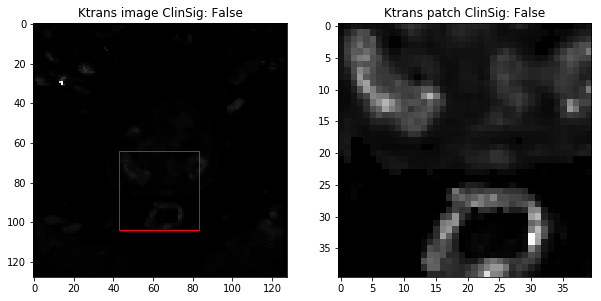

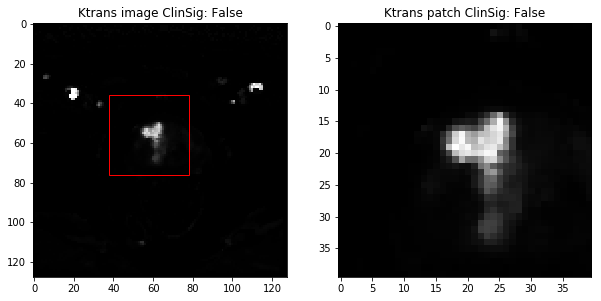

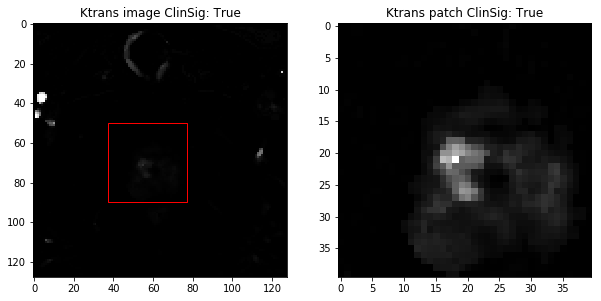

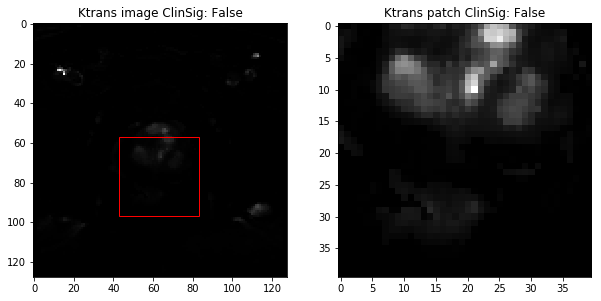

In [47]:
dataframe = training_ktrans_imgs_dataframe
number_of_plots = 4
indexes = np.random.randint(size= number_of_plots, low= 0 , high=len(dataframe))
for index in indexes:
    plot_ktrans_image_and_patch(dataframe, index)

In [48]:
def fill_predictions_ktrans_images():
    suma = 0
    for i in range (len(training_ktrans_imgs_dataframe)):
        row = training_ktrans_imgs_dataframe.iloc[i]
        z,y,x = row.KimgPatch3D.shape
        predict = classifier_ALL.predict(row.KimgPatch3D.reshape(1,z*y*x))
        suma = suma + predict 
        print (i,predict, "this is i, predict, before")
        training_ktrans_imgs_dataframe.at[i,"Predictions"] = predict
        print (i,training_ktrans_imgs_dataframe.Predictions.iloc[i], predict, "this is i, Predictions, predict, after")
    clear_output()
    print ("hay {} casos positivos de cancer.".format(suma))

fill_predictions_ktrans_images()

hay [24.] casos positivos de cancer.


In [49]:
true_positive_training_ktrans_imgs_dataframe = training_ktrans_imgs_dataframe[(training_ktrans_imgs_dataframe.Predictions == 1) &
                                                                              (training_ktrans_imgs_dataframe.ClinSig ==1)]
true_negative_training_ktrans_imgs_dataframe = training_ktrans_imgs_dataframe[(training_ktrans_imgs_dataframe.Predictions == 0) &
                                                                              (training_ktrans_imgs_dataframe.ClinSig ==0)]
false_positive_training_ktrans_imgs_dataframe = training_ktrans_imgs_dataframe[(training_ktrans_imgs_dataframe.Predictions == 1) &
                                                                               (training_ktrans_imgs_dataframe.ClinSig ==0)]
false_negative_training_ktrans_imgs_dataframe = training_ktrans_imgs_dataframe[(training_ktrans_imgs_dataframe.Predictions == 0) &
                                                                               (training_ktrans_imgs_dataframe.ClinSig ==1)]
print ("There is a total of {} true positive cases".format(len(true_positive_training_ktrans_imgs_dataframe)))
print ("There is a total of {} true negative cases".format(len(true_negative_training_ktrans_imgs_dataframe)))
print ("There is a total of {} false positive cases".format(len(false_positive_training_ktrans_imgs_dataframe)))
print ("There is a total of {} false negative cases".format(len(false_negative_training_ktrans_imgs_dataframe)))

print ("The length of the dataset is {} = {} {} {} {}".format(len(training_ktrans_imgs_dataframe), 
                                                              len(true_positive_training_ktrans_imgs_dataframe), 
                                                              len(true_negative_training_ktrans_imgs_dataframe),
                                                              len(false_positive_training_ktrans_imgs_dataframe), 
                                                              len(false_negative_training_ktrans_imgs_dataframe)))

There is a total of 22 true positive cases
There is a total of 260 true negative cases
There is a total of 2 false positive cases
There is a total of 55 false negative cases
The length of the dataset is 339 = 22 260 2 55


In [50]:
def plot_dataframe_predictions_and_clinSig(dataframe, samples):
    import matplotlib.patches as patches
    dataframe.reset_index(drop=True)
    dataframe.index = pd.RangeIndex(len(dataframe))
    indexes = np.random.randint(low = 0 , high= len(dataframe), size=samples)
    for index in indexes:
        row = dataframe.iloc[index]
        patient_id = row.ProxID
        finding_id = row.fid
        predicted_ClinSig = row.Predictions
        ClinSig = row.ClinSig
        kimage_3D = row.Kimg3D
        kimagePatch_3D = row.KimgPatch3D
        i,j,k = row.ijk.split()
        i = int (i)
        j = int(j)
        k = int(k)
        window = 40
        rectangle = patches.Rectangle((i- window/2  ,j - window/2),window,window,linewidth=1,edgecolor='red',facecolor='none')
        plt.figure(figsize=(10,10))
        plt.subplot(121), plt.imshow(kimage_3D[k], cmap='gray'), plt.title("Ktrans Image 3D - {} - fid {}".format(patient_id, finding_id))
        plt.text(kimage_3D.shape[2]//4, kimage_3D.shape[2]//10, 
                 'Predicted : {} , Clin Sig : {}'.format(predicted_ClinSig, ClinSig), style='italic',
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})
        plt.gca().add_patch(rectangle)
        plt.subplot(122), plt.imshow(kimagePatch_3D[1], cmap='gray'), plt.title("Ktrans image patch - {} - fid {}".format(patient_id, finding_id))

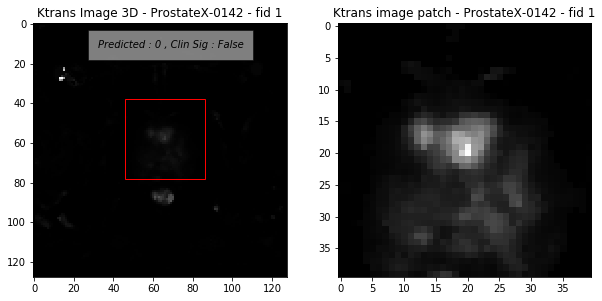

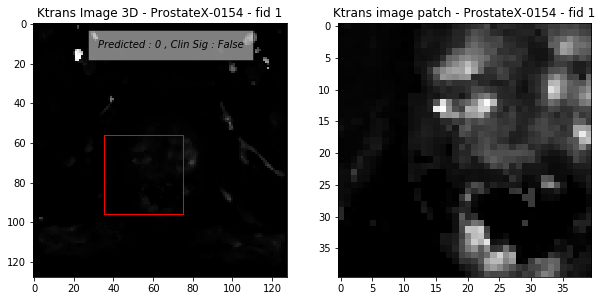

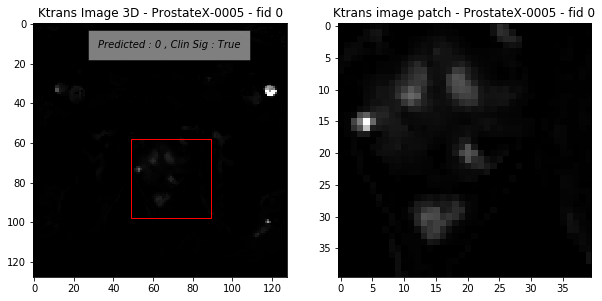

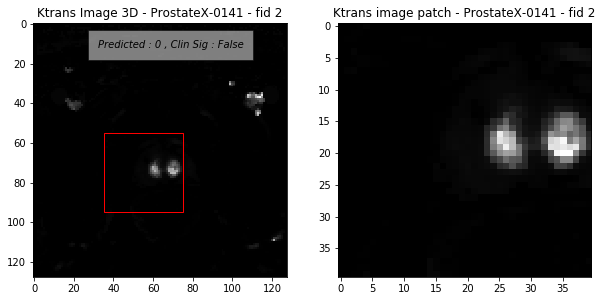

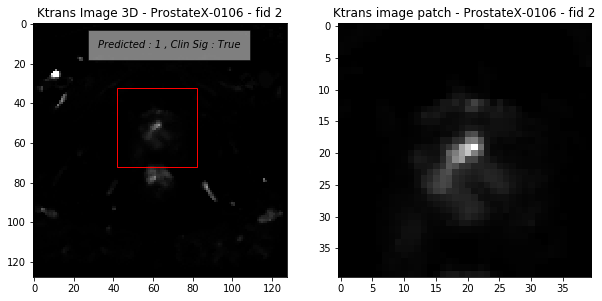

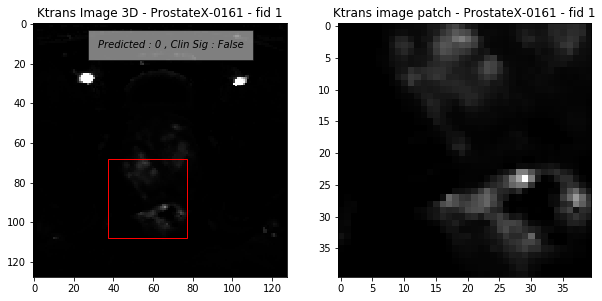

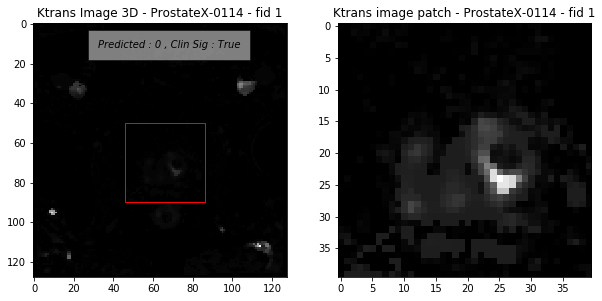

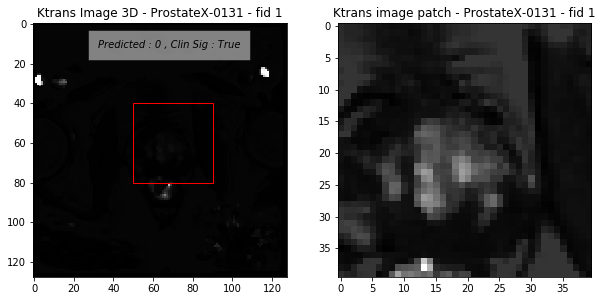

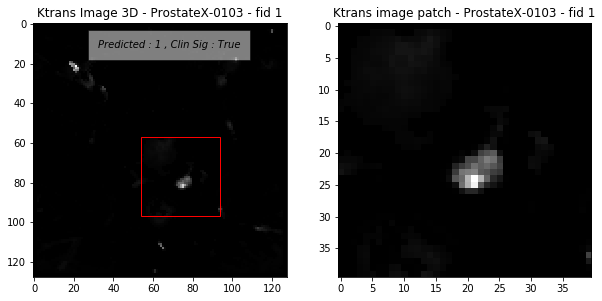

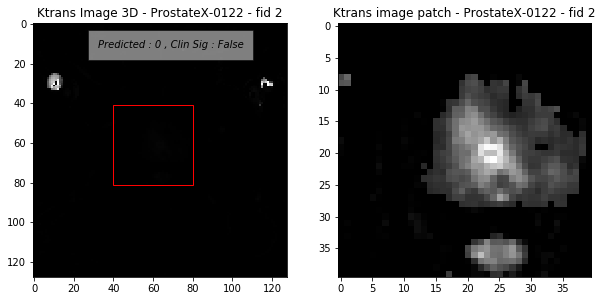

In [51]:
dataframe = training_ktrans_imgs_dataframe
samples = 10
plot_dataframe_predictions_and_clinSig(dataframe, samples)

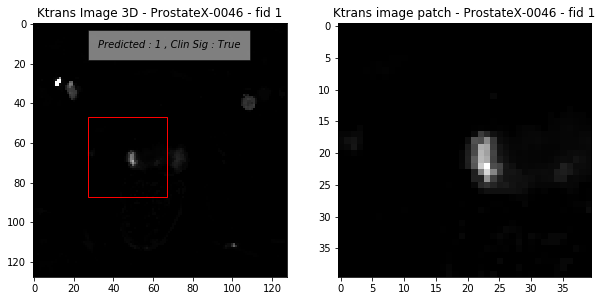

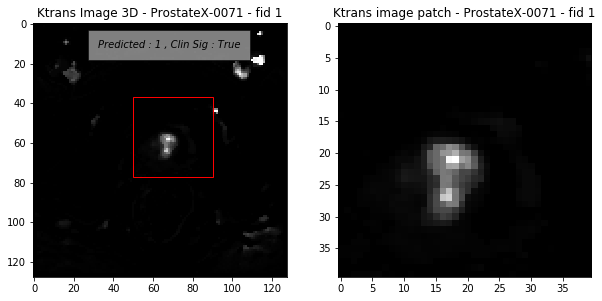

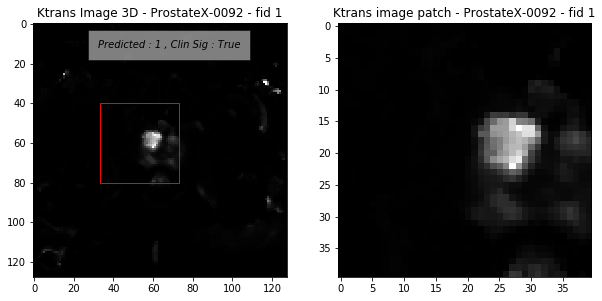

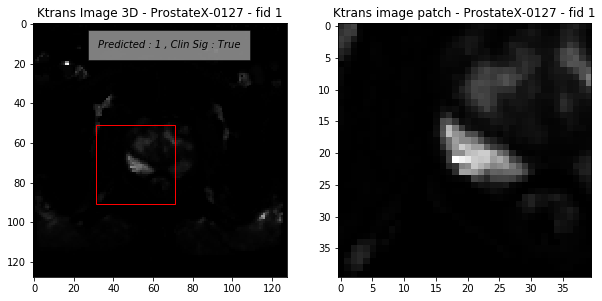

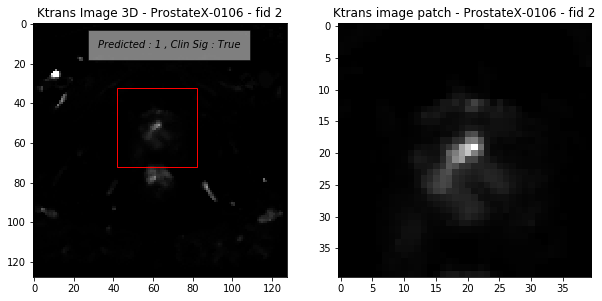

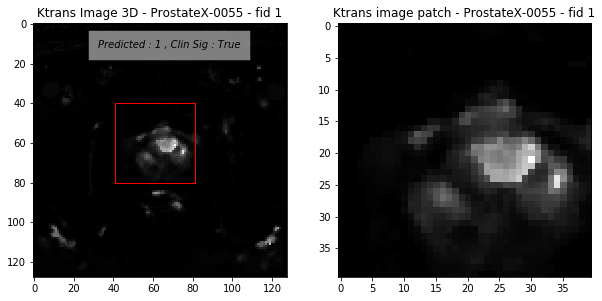

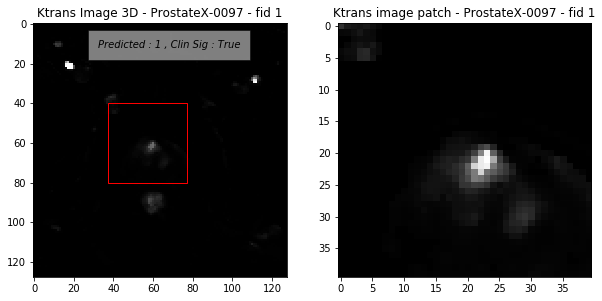

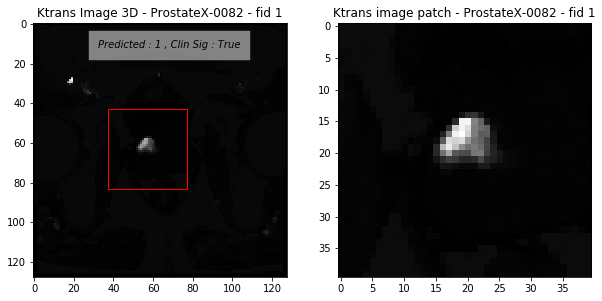

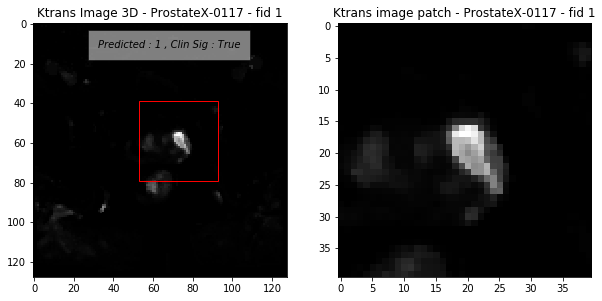

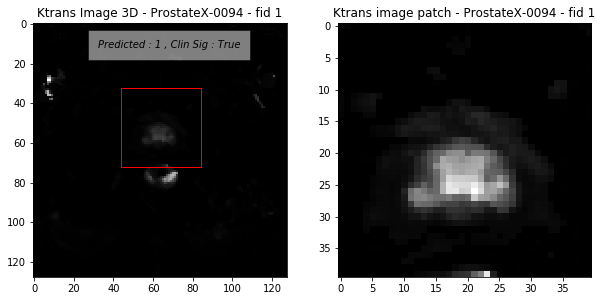

In [52]:
dataframe = true_positive_training_ktrans_imgs_dataframe
samples = 10
plot_dataframe_predictions_and_clinSig(dataframe, samples)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


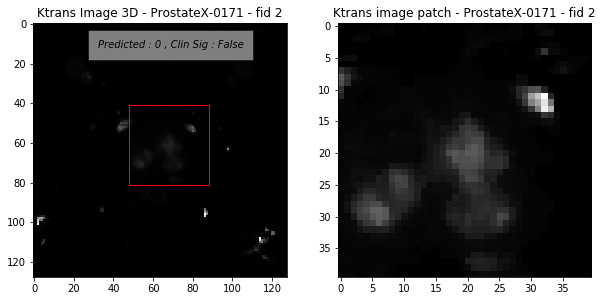

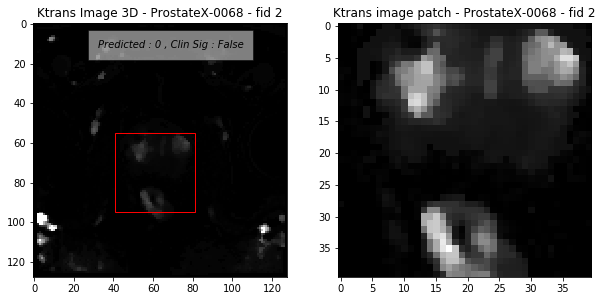

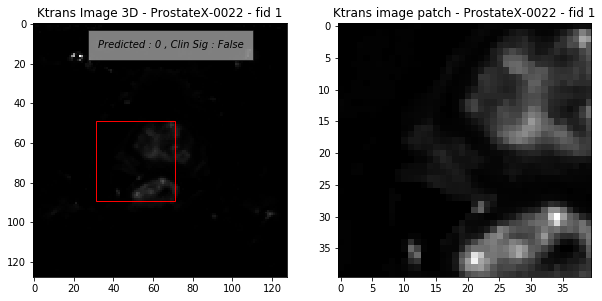

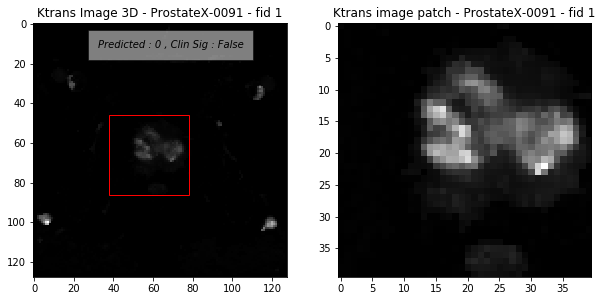

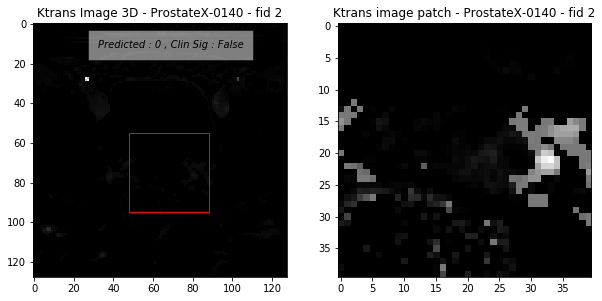

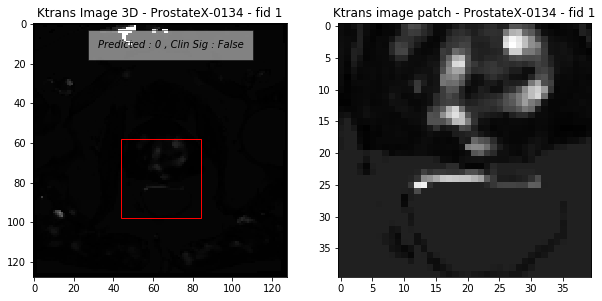

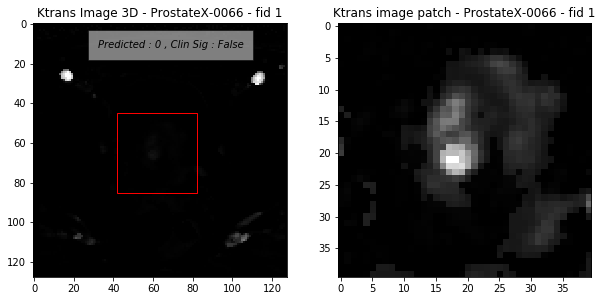

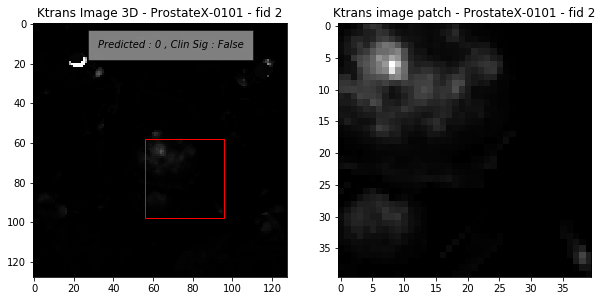

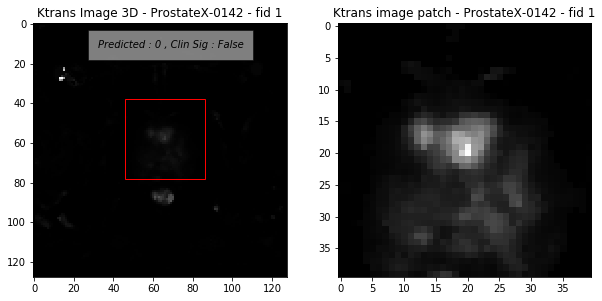

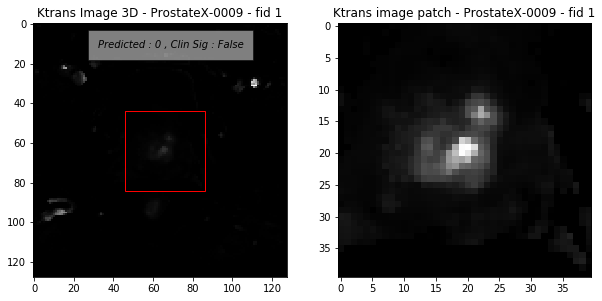

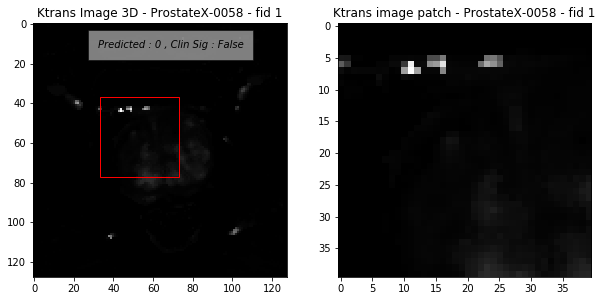

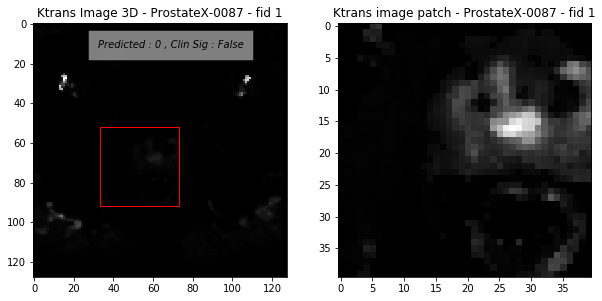

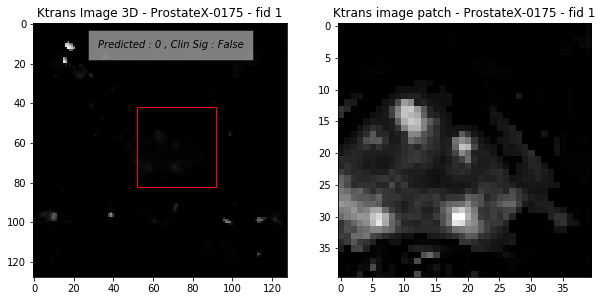

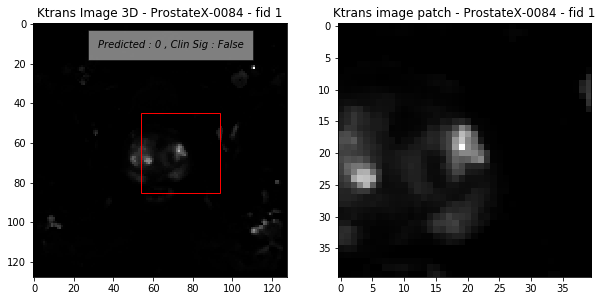

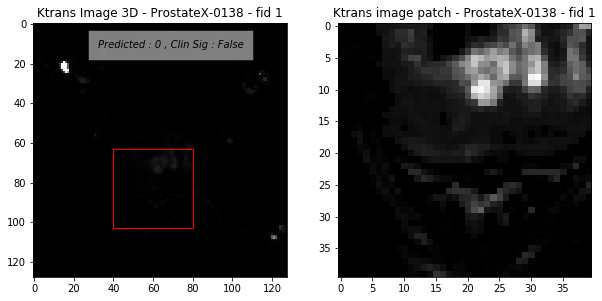

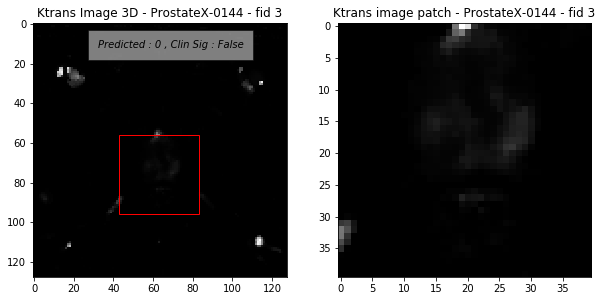

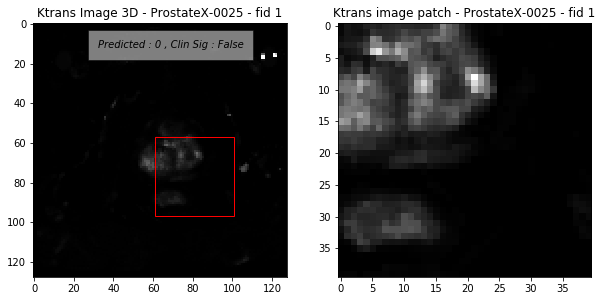

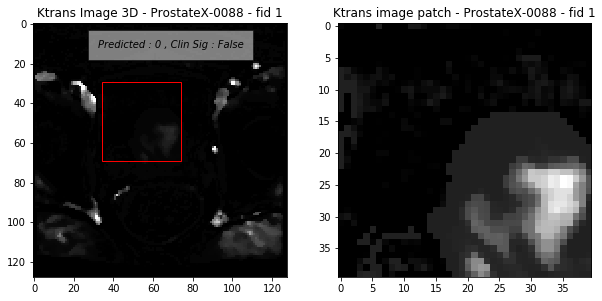

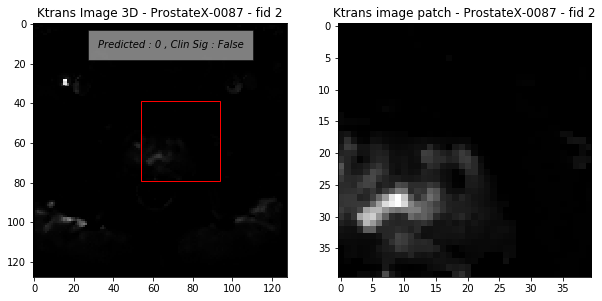

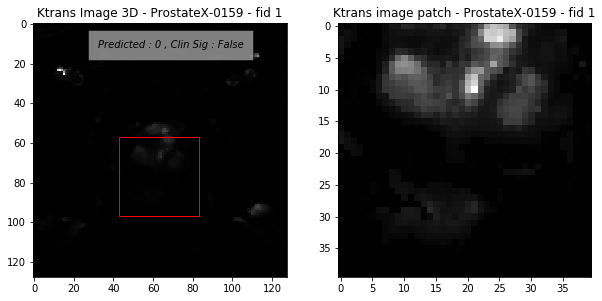

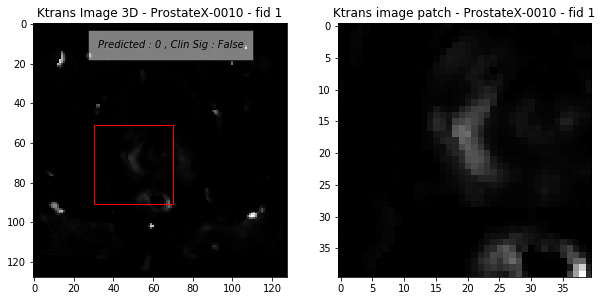

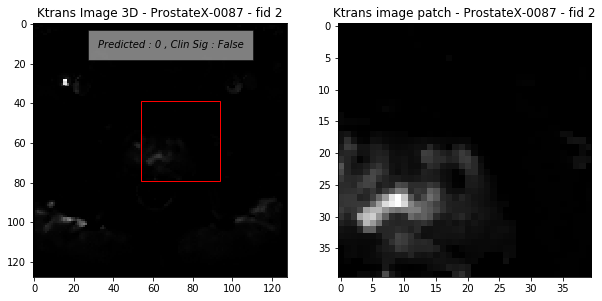

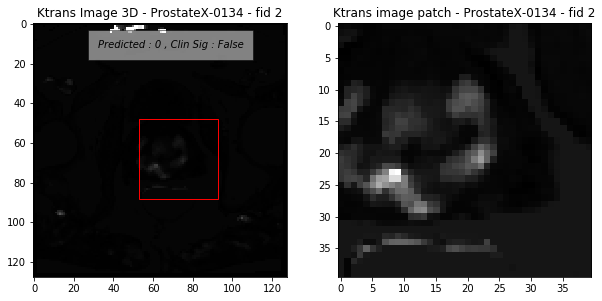

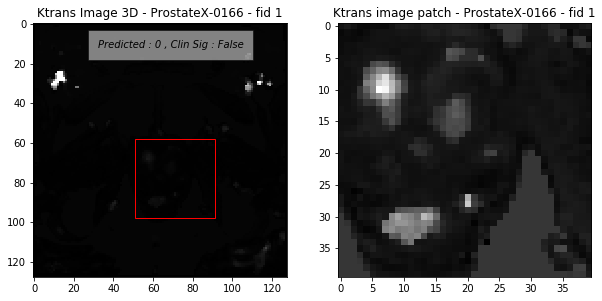

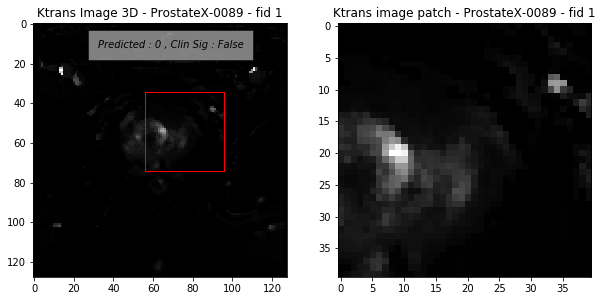

In [53]:
dataframe = true_negative_training_ktrans_imgs_dataframe
samples = 25
plot_dataframe_predictions_and_clinSig(dataframe, samples)

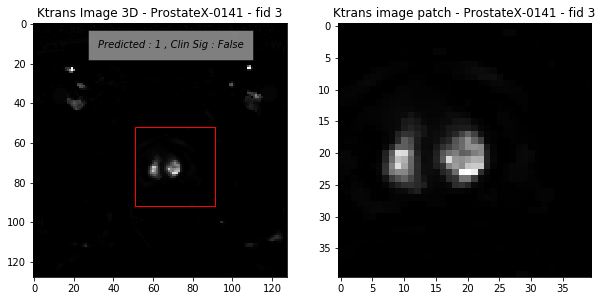

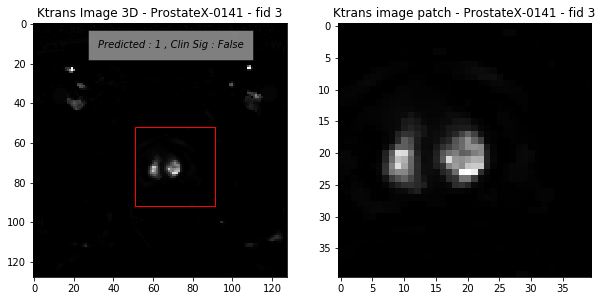

In [54]:
dataframe = false_positive_training_ktrans_imgs_dataframe
samples = 2
plot_dataframe_predictions_and_clinSig(dataframe, samples)

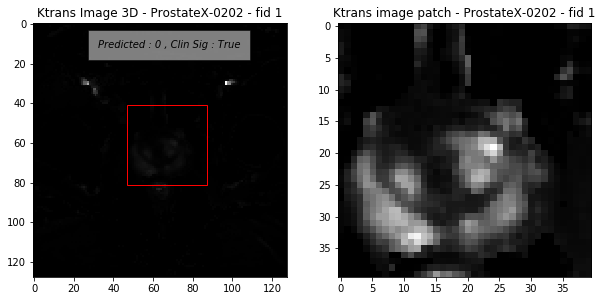

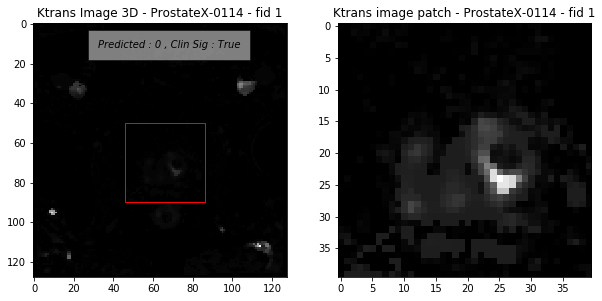

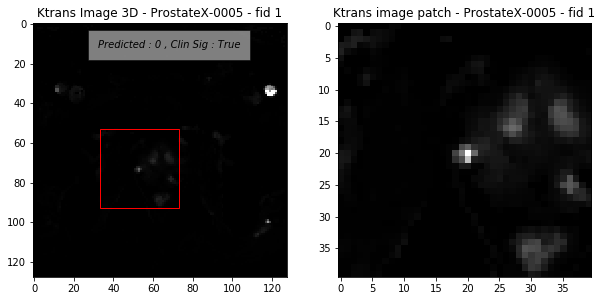

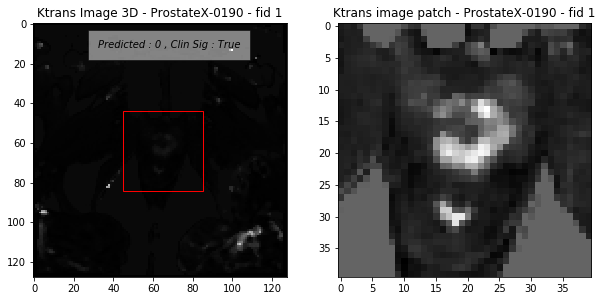

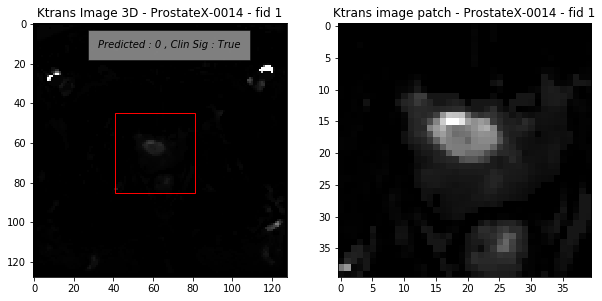

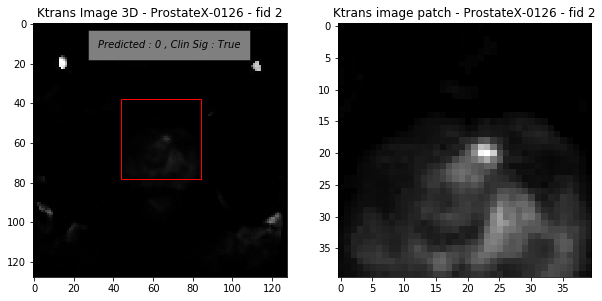

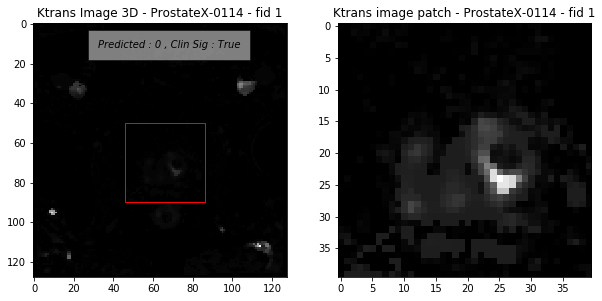

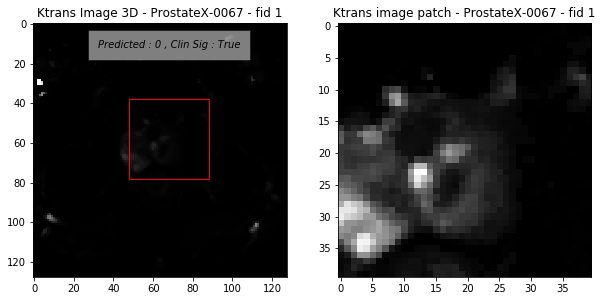

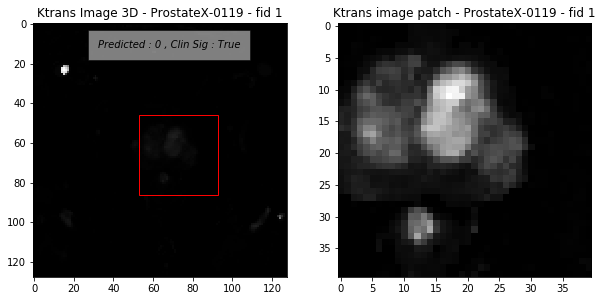

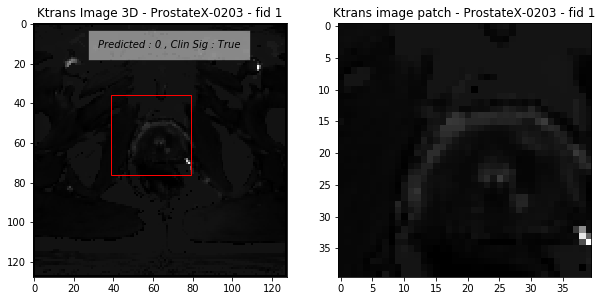

In [55]:
dataframe = false_negative_training_ktrans_imgs_dataframe
samples = 10
plot_dataframe_predictions_and_clinSig(dataframe, samples)

(16, 128, 128)


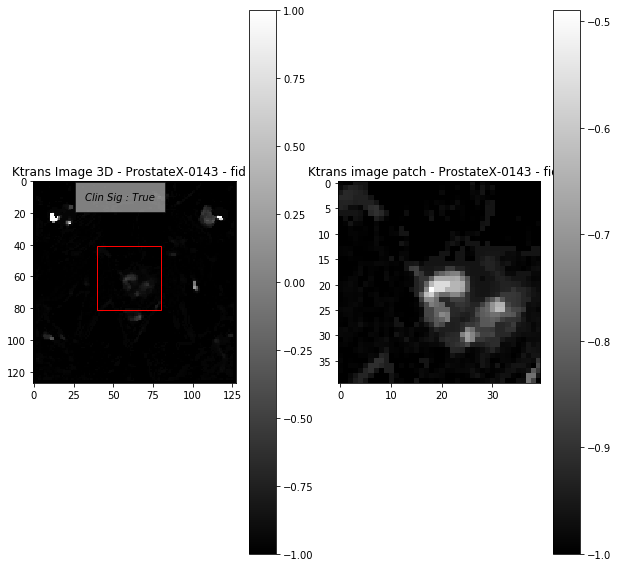

In [56]:
import matplotlib.patches as patches
patient_id = "ProstateX-0143"
kimage_3D = training_ktrans_imgs_dataframe[training_ktrans_imgs_dataframe.ProxID == patient_id].Kimg3D.values[0]
print(kimage_3D.shape)
kimagePatch_3D = training_ktrans_imgs_dataframe[training_ktrans_imgs_dataframe.ProxID == patient_id].KimgPatch3D.values[0]
finding_id = training_ktrans_imgs_dataframe[training_ktrans_imgs_dataframe.ProxID == patient_id].fid.values[0]
predicted_ClinSig = training_ktrans_imgs_dataframe[training_ktrans_imgs_dataframe.ProxID == patient_id].Predictions.values[0]
ClinSig = training_ktrans_imgs_dataframe[training_ktrans_imgs_dataframe.ProxID == patient_id].ClinSig.values[0]
ijk = training_ktrans_imgs_dataframe[training_ktrans_imgs_dataframe.ProxID == patient_id].ijk.values[0]
ijk = ijk.split()
i = int (ijk[0])
j = int (ijk[1])
k = int (ijk[2])
window = 40
rectangle = patches.Rectangle((i- window/2  ,j - window/2),window,window,linewidth=1,edgecolor='red',facecolor='none')
plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(kimage_3D[k], cmap='gray'), plt.title("Ktrans Image 3D - {} - fid {}".format(patient_id, finding_id))
plt.text(kimage_3D.shape[2]//4, kimage_3D.shape[2]//10, 
        'Clin Sig : {}'.format(ClinSig), style='italic',
bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})
plt.colorbar()
plt.gca().add_patch(rectangle)
plt.subplot(122), plt.imshow(kimagePatch_3D[1], cmap='gray'), plt.title("Ktrans image patch - {} - fid {}".format(patient_id, finding_id))
plt.colorbar()

(16, 128, 128)


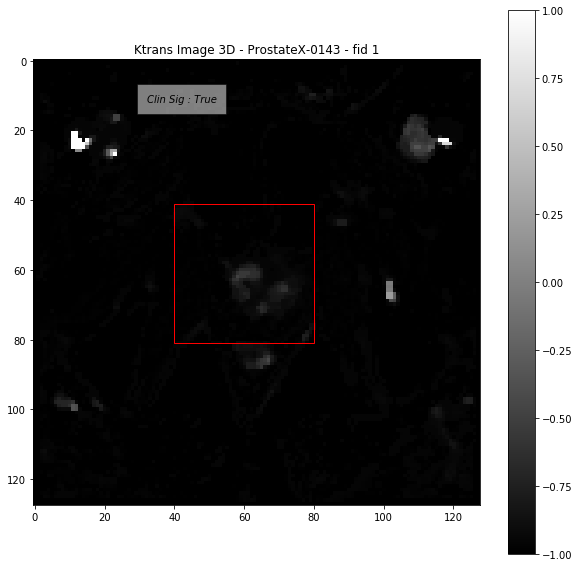

In [57]:
import matplotlib.patches as patches
patient_id = "ProstateX-0143"
kimage_3D = training_ktrans_imgs_dataframe[training_ktrans_imgs_dataframe.ProxID == patient_id].Kimg3D.values[0]
print(kimage_3D.shape)
kimagePatch_3D = training_ktrans_imgs_dataframe[training_ktrans_imgs_dataframe.ProxID == patient_id].KimgPatch3D.values[0]
finding_id = training_ktrans_imgs_dataframe[training_ktrans_imgs_dataframe.ProxID == patient_id].fid.values[0]
predicted_ClinSig = training_ktrans_imgs_dataframe[training_ktrans_imgs_dataframe.ProxID == patient_id].Predictions.values[0]
ClinSig = training_ktrans_imgs_dataframe[training_ktrans_imgs_dataframe.ProxID == patient_id].ClinSig.values[0]
ijk = training_ktrans_imgs_dataframe[training_ktrans_imgs_dataframe.ProxID == patient_id].ijk.values[0]
ijk = ijk.split()
i = int (ijk[0])
j = int (ijk[1])
k = int (ijk[2])
window = 40
plt.figure(figsize=(10,10))
rectangle = patches.Rectangle((i- window/2  ,j - window/2),window,window,linewidth=1,edgecolor='red',facecolor='none')
plt.imshow(kimage_3D[k], cmap='gray'), plt.title("Ktrans Image 3D - {} - fid {}".format(patient_id, finding_id))
plt.text(kimage_3D.shape[2]//4, kimage_3D.shape[2]//10, 
        'Clin Sig : {}'.format(ClinSig), style='italic',
bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})
plt.colorbar()
plt.gca().add_patch(rectangle)

In [58]:
training_MRI_imgs_dataframe.reset_index(drop=True)
training_MRI_imgs_dataframe.index = pd.RangeIndex(len(training_MRI_imgs_dataframe))
display(training_MRI_imgs_dataframe[["ProxID", "fid", "ClinSig"]].iloc[30:40])

,ProxID,fid,ClinSig
30,ProstateX-0002,1,True
31,ProstateX-0002,1,True
32,ProstateX-0002,1,True
33,ProstateX-0002,2,False
34,ProstateX-0002,2,False
35,ProstateX-0002,2,False
36,ProstateX-0002,2,False
37,ProstateX-0002,2,False
38,ProstateX-0002,2,False
39,ProstateX-0002,2,False


In [59]:
goal_MRI_dataframe = training_MRI_imgs_dataframe[(training_MRI_imgs_dataframe.fid == 1) & 
                                                 (training_MRI_imgs_dataframe.ProxID == "ProstateX-0002")]

goal_MRI_dataframe.reset_index(drop=True)

goal_MRI_dataframe.index = pd.RangeIndex(len(goal_MRI_dataframe))

display(goal_MRI_dataframe[["ProxID", "fid", "ClinSig"]])

,ProxID,fid,ClinSig
0,ProstateX-0002,1,True
1,ProstateX-0002,1,True
2,ProstateX-0002,1,True
3,ProstateX-0002,1,True
4,ProstateX-0002,1,True
5,ProstateX-0002,1,True
6,ProstateX-0002,1,True
7,ProstateX-0002,1,True
8,ProstateX-0002,1,True
9,ProstateX-0002,1,True


In [60]:
goal_ktrans_dataframe = training_ktrans_imgs_dataframe[(training_ktrans_imgs_dataframe.fid == 1) & 
                                                       (training_ktrans_imgs_dataframe.ProxID == "ProstateX-0002")]
goal_ktrans_dataframe.reset_index(drop=True)
goal_ktrans_dataframe.index = pd.RangeIndex(len(goal_ktrans_dataframe))
display(goal_ktrans_dataframe)

,ProxID,fid,pos_x,zone,ClinSig,pos_y,WorldMatrix,ijk,Kimg3D,KimgPatch3D,State,Predictions
0,ProstateX-0002,1,-27.0102 41.5467 -26.0469,PZ,True,-27.0102 41.5467 -26.0469,"1.5,3.07655e-010,7.98512e-017,-104.284,-2.9890...",52 73 11,"[[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -...","[[[-0.959706935108019, -1.0, -0.99655868639482...",False,0


These are the images for the patient ProstateX-0002, fid = 1, with a malignancy status


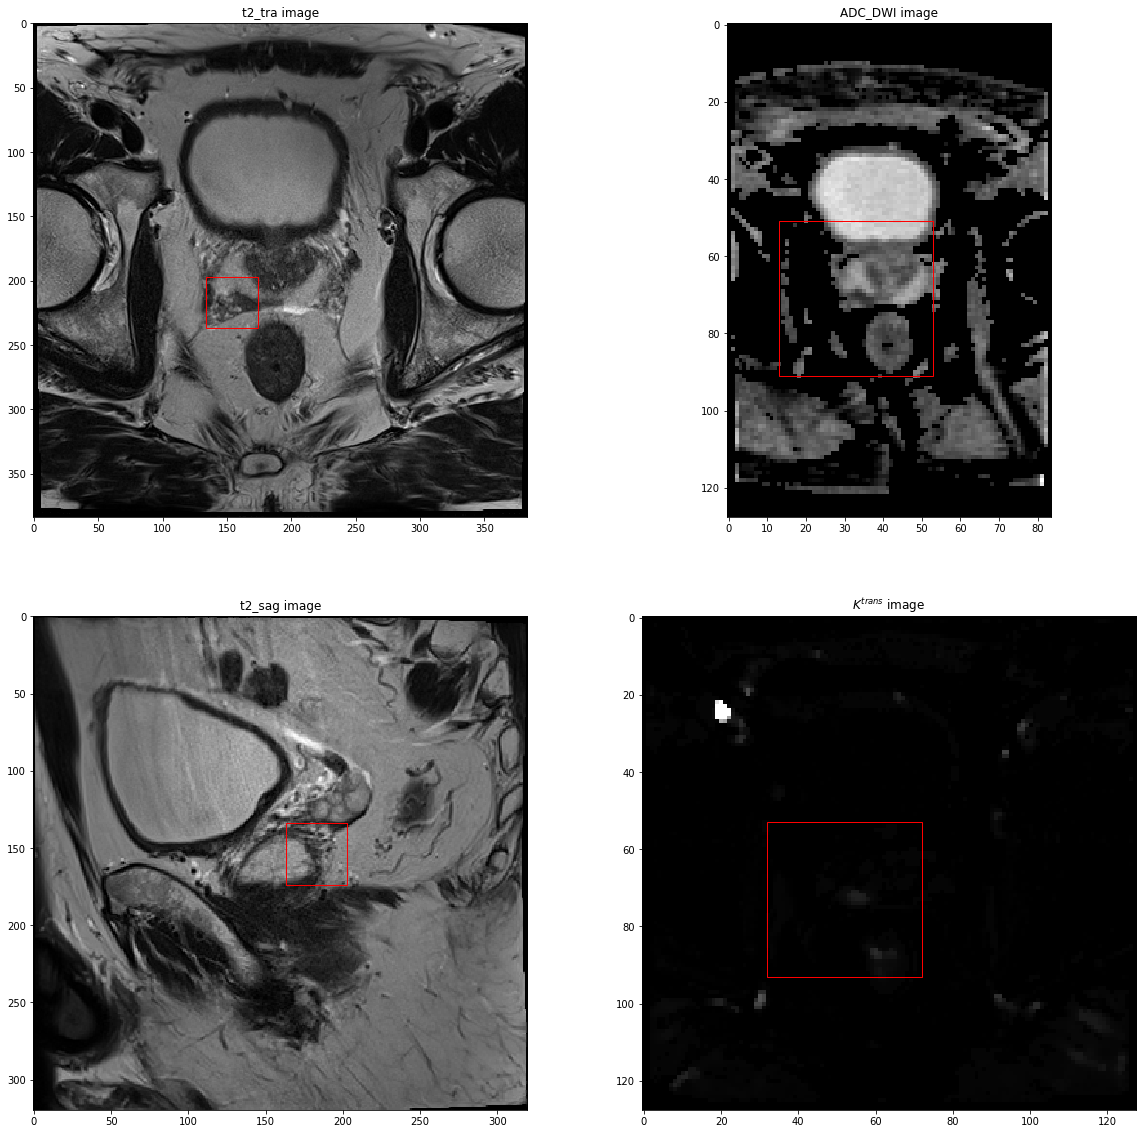

In [61]:
print("These are the images for the patient ProstateX-0002, fid = 1, with a malignancy status")
#t2_tra
window = 40
index = 9
ijk = goal_MRI_dataframe.ijk.iloc[index].split()
i = int(ijk[0])
j = int(ijk[1])
k = int(ijk[2])
rectangle = patches.Rectangle((i- window/2  ,j - window/2),window,window,linewidth=1,edgecolor='red',facecolor='none')
t2_tra_image = goal_MRI_dataframe.iloc[index].MRI3D
plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(t2_tra_image[k], cmap="gray") , plt.title("t2_tra image")
plt.gca().add_patch(rectangle)
#ADC DWI
index = 0
ijk = goal_MRI_dataframe.ijk.iloc[index].split()
i = int(ijk[0])
j = int(ijk[1])
k = int(ijk[2])
rectangle = patches.Rectangle((i- window/2  ,j - window/2),window,window,linewidth=1,edgecolor='red',facecolor='none')
ADC_DWI_image = goal_MRI_dataframe.iloc[index].MRI3D
plt.subplot(222), plt.imshow(ADC_DWI_image[k], cmap="gray") , plt.title("ADC_DWI image")
plt.gca().add_patch(rectangle)
#t2_sag
index = 8
ijk = goal_MRI_dataframe.ijk.iloc[index].split()
i = int(ijk[0])
j = int(ijk[1])
k = int(ijk[2])
rectangle = patches.Rectangle((i- window/2  ,j - window/2),window,window,linewidth=1,edgecolor='red',facecolor='none')
t2_sag_image = goal_MRI_dataframe.iloc[index].MRI3D
plt.subplot(223), plt.imshow(t2_sag_image[k], cmap="gray") , plt.title("t2_sag image")
plt.gca().add_patch(rectangle)
#Ktrans DCE
index = 0
ijk = goal_ktrans_dataframe.ijk.iloc[index].split()
i = int(ijk[0])
j = int(ijk[1])
k = int(ijk[2])
rectangle = patches.Rectangle((i- window/2  ,j - window/2),window,window,linewidth=1,edgecolor='red',facecolor='none')
k_trans_image = goal_ktrans_dataframe.iloc[index].Kimg3D
plt.subplot(224), plt.imshow(k_trans_image[k], cmap="gray") , plt.title("$K^{trans}$ image")
plt.gca().add_patch(rectangle)